In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy.stats import norm
import matplotlib.lines as mlines
from matplotlib.collections import PathCollection



plt.rcParams['figure.dpi'] = 300
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "cm"

#Load Data 

MRdata = pd.read_csv('../Data/Migration_Compiled.csv', delimiter=",")
T0data = pd.read_csv('../Data/Migration_T0_Fill.csv', delimiter=",")



In [2]:
#Imported paramters and GFP-CFU Mapping

#log cfu to log gfp mapping
def lctolg(x,a,b,c):
    return a*np.tanh((x-b)/c)

#lof gfp to log cfu mapping
def lgtolc(x,a,b,c):
    return (c/2)*np.log((1+x/a)/(1-x/a))+b

parami=np.array([4.00229685, 0.8844725, 3.064446])


In [3]:
#Condition titles and timepoints for the migration data

conditions = MRdata['Condition'].unique()

conditions_order = ['High -', 'Low -', 'High +', 'Low +']



conditions_titles = {
    'High -': 'High GFP ',
    'Low -': 'Low GFP',
    'High +': 'High GFP',
    'Low +': 'Low GFP'}


timepoints = MRdata['Time'].unique()

#Fit the data at each timepoint to a Gaussian Mixture Model with 2 components and store the means, stds and weights


timepoint_averages = np.zeros((4,3))
timepoint_stds = np.zeros((4,3))

ttimepoint_averages = np.zeros((4,3))
ttimepoint_stds = np.zeros((4,3))


means_lst = np.zeros((4,3,2))
std_lst = np.zeros((4,3,2))
weights_lst = np.zeros((4,3,2))
nums_lst = np.zeros((4,3,2))

tmeans_lst = np.zeros((4,3,2))
tstd_lst = np.zeros((4,3,2))
tweights_lst = np.zeros((4,3,2))
tnums_lst = np.zeros((4,3,2))



for i,condition in enumerate(conditions_order):
    for j,timepoint in enumerate(timepoints):

        subset_v = MRdata[(MRdata['Condition'] == condition) & (MRdata['Time'] == timepoint)]['Green'].values.reshape(-1, 1)
        subset = np.log10(subset_v)
        
                
        timepoint_averages[i, j] = np.mean(subset)
        timepoint_stds[i, j] = np.std(subset)
        
        #transformed data for GMM fits
        
        subset=lgtolc(subset,*parami)
        
        ttimepoint_averages[i, j] = np.mean(subset)
        ttimepoint_stds[i, j] = np.std(subset)
        
        if j == 0:  
            gmm = GaussianMixture(n_components=1, random_state=0)
        else:
            gmm = GaussianMixture(n_components=2, random_state=0)
            
        gmm.fit(subset)
        
        if j == 0:  # For the first timepoint with only one Gaussian
            means_lst[i, j, 0] = gmm.means_.flatten()[0]
            std_lst[i, j, 0] = np.sqrt(gmm.covariances_).flatten()[0]
            weights_lst[i, j, 0] = gmm.weights_.flatten()[0]
            nums_lst[i,j,0] = np.round(len(subset)*weights_lst[i, j, 0],0)
            
            means_lst[i, j, 1] = means_lst[i, j, 0]
            std_lst[i, j, 1] = std_lst[i, j, 0]
            weights_lst[i, j, 1] = weights_lst[i, j, 0]
            nums_lst[i,j,1] = np.round(len(subset)*weights_lst[i, j, 1],0)
            
            tmeans_lst[i,j,:]=means_lst[i,j,:]
            tstd_lst[i,j,:]=std_lst[i,j,:]
            tweights_lst[i,j,:]=weights_lst[i,j,:]
        
            means_lst[i,j,:]=lctolg(means_lst[i,j,:], *parami)
            std_lst[i,j,:]=lctolg(std_lst[i,j,:], *parami)
            

        else:
            sorted_indices = np.argsort(gmm.means_.flatten())
            means_lst[i,j,:] = gmm.means_.reshape(2,)[sorted_indices]
            std_lst[i,j,:] = np.sqrt(gmm.covariances_).reshape(2,)[sorted_indices]
            weights_lst[i,j,:] = gmm.weights_.reshape(2,)[sorted_indices]
            nums_lst[i,j,:] = np.round(len(subset)*weights_lst[i,j,:],0)
            
            tmeans_lst[i,j,:]=means_lst[i,j,:]
            tstd_lst[i,j,:]=std_lst[i,j,:]
            tweights_lst[i,j,:]=weights_lst[i,j,:]
        
            means_lst[i,j,:]=lctolg(means_lst[i,j,:], *parami)
            std_lst[i,j,:]=lctolg(std_lst[i,j,:], *parami)


In [4]:
#Calculating the thresholds in GFP data to visualize against T0 data

thres = []
for c in conditions:
    if 'High' in c:
        a = min(MRdata[(MRdata['Condition'] == c) & (MRdata['Time'] == 'T0')]["Green"])
    else:
        a = max(MRdata[(MRdata['Condition'] == c) & (MRdata['Time'] == 'T0')]["Green"])
    thres.append(a)

In [5]:
thres2 = []
for c in conditions:
    if 'High' in c:
        a = max(MRdata[(MRdata['Condition'] == c) & (MRdata['Time'] == 'T0')]["Green"])
    else:
        a = min(MRdata[(MRdata['Condition'] == c) & (MRdata['Time'] == 'T0')]["Green"])
    thres2.append(a)

In [6]:
np.round(thres,2)

array([850., 842., 612., 601.])

In [7]:
np.round(thres2,2)

array([3924. , 4186. ,   43.6,   50.8])

/var/folders/rq/14yl4zpx5sj3qf3qbj4k9vj92w4ltc/T/ipykernel_5166/3355160300.py:9: RuntimeWarning: invalid value encountered in log
  return (c/2)*np.log((1+x/a)/(1-x/a))+b


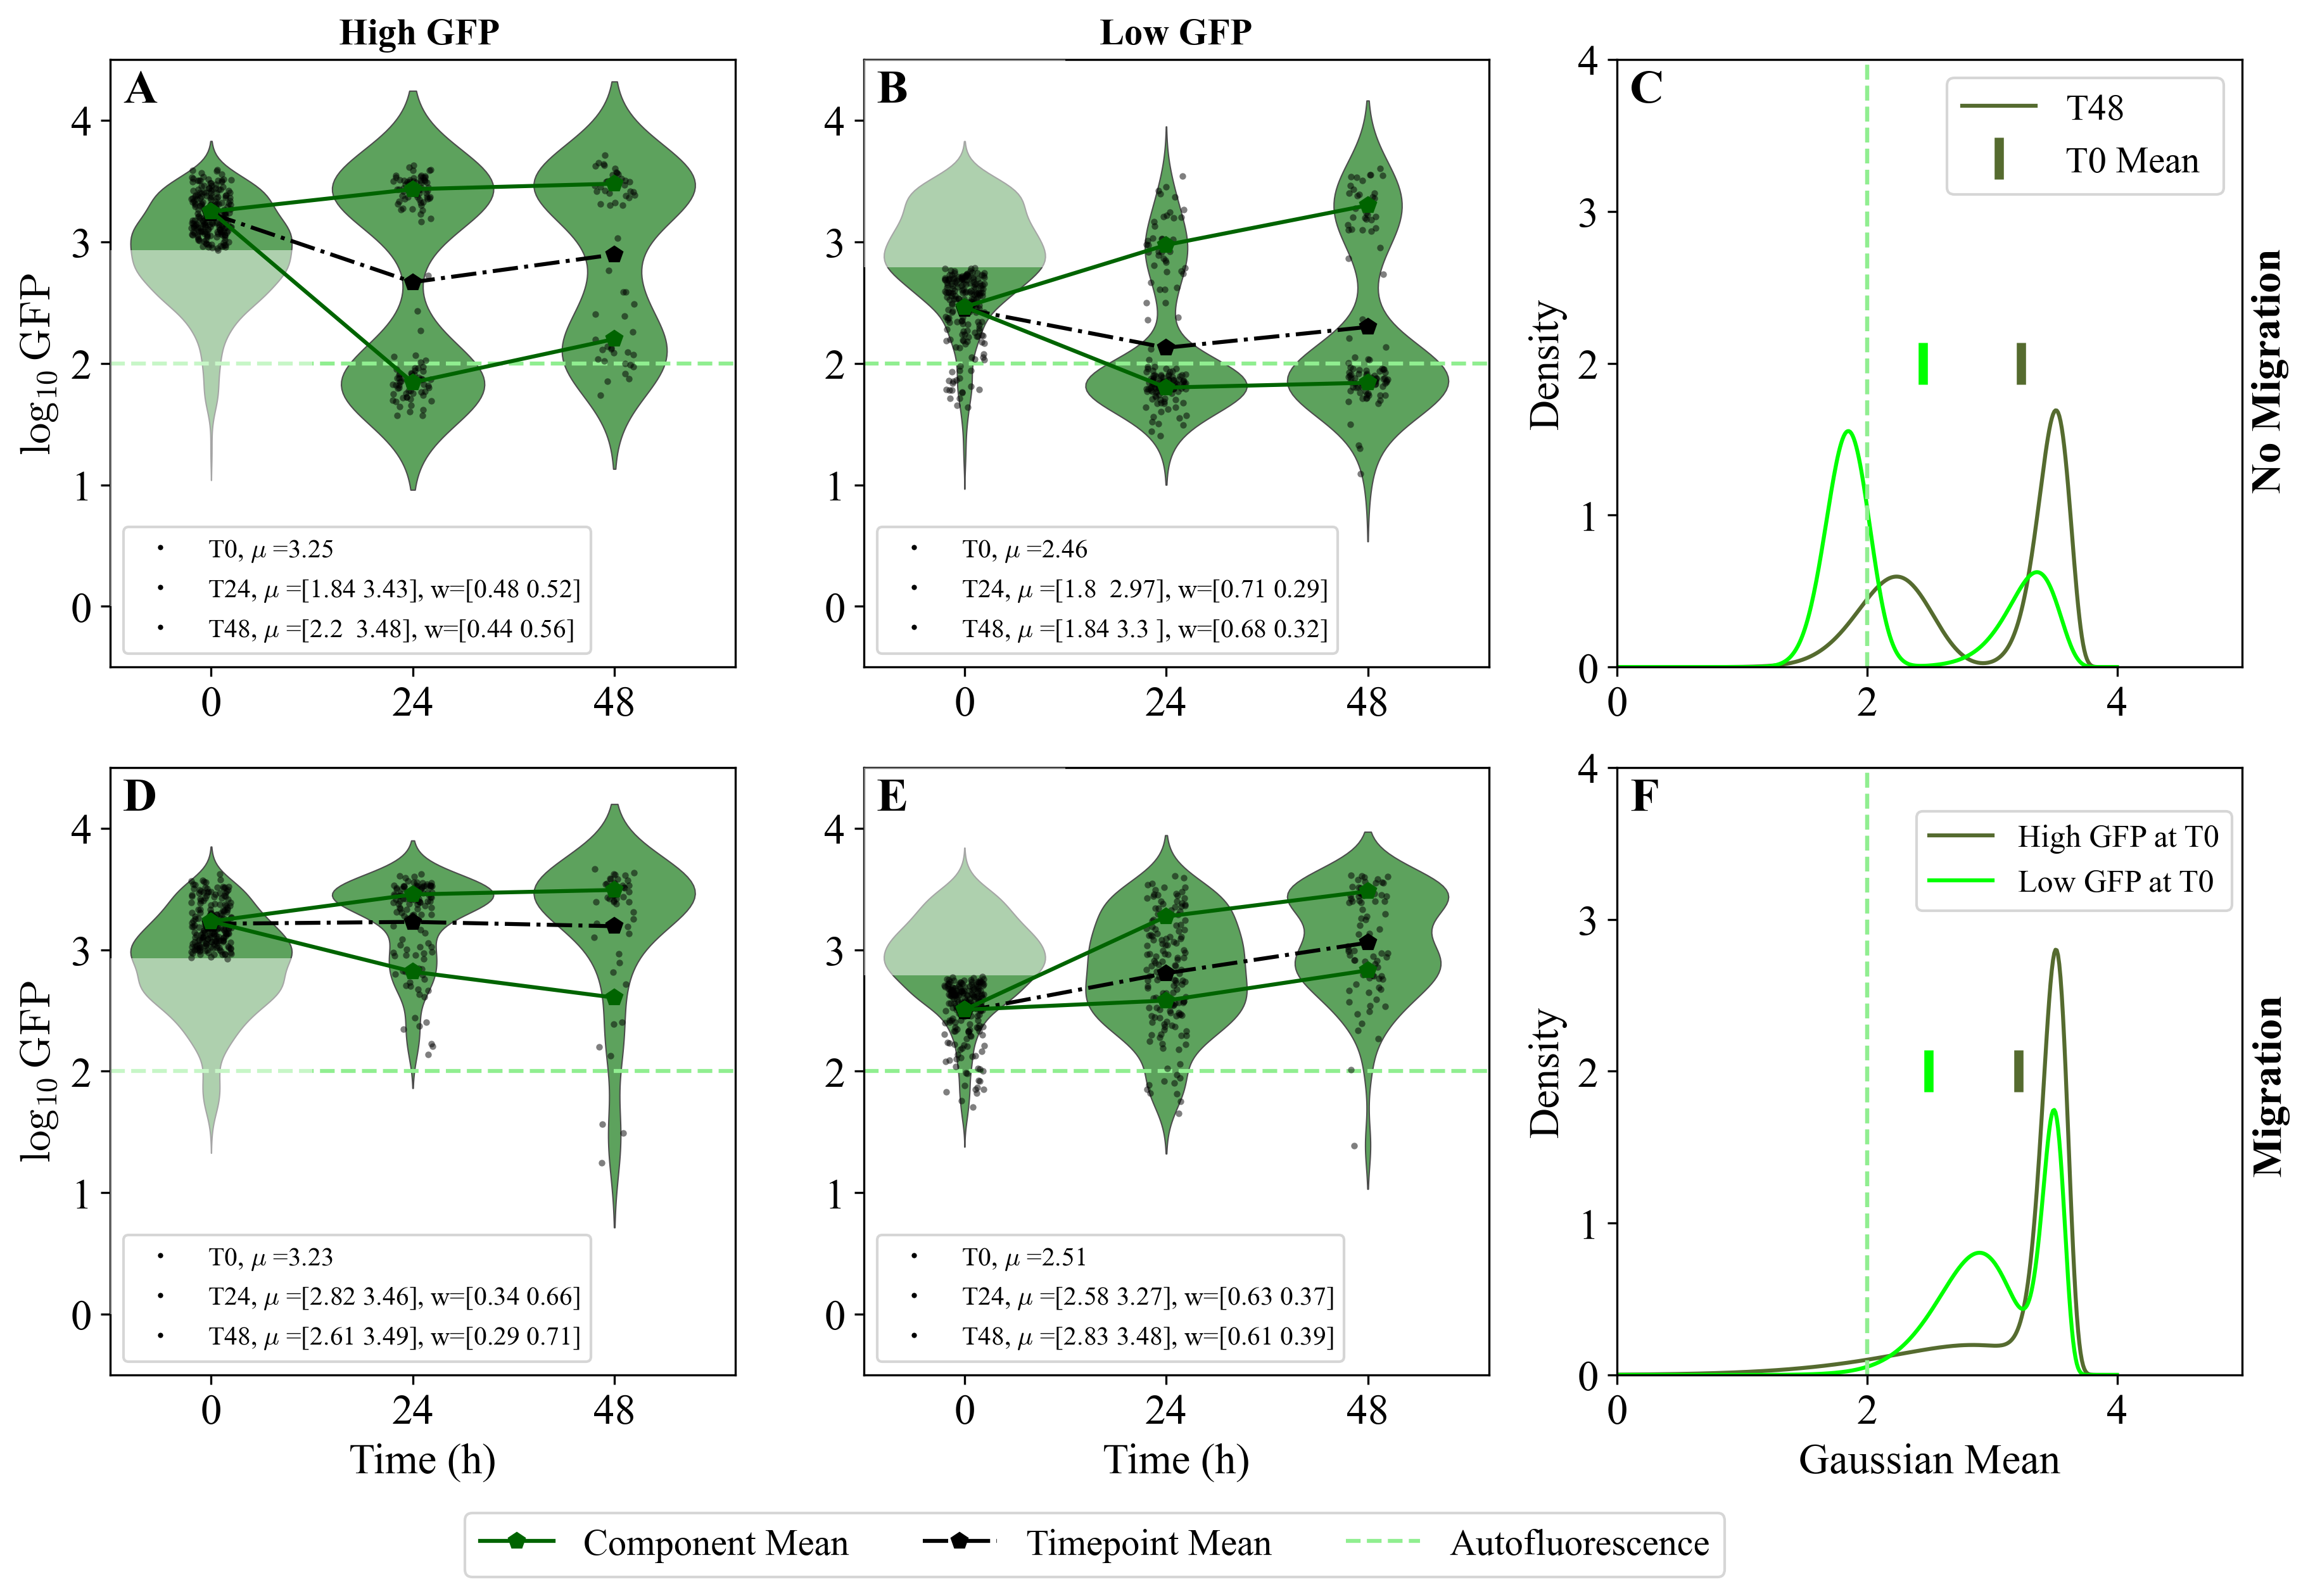

In [8]:
Times_p = [0,24,48]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8), sharex=False, sharey=False)



for q,condition in enumerate(conditions_order):
    row = q // 2
    col = q % 2
    
    #plots showing the GFP data and T0 data (light green) along with means and weights of the transformed GMM fits.
   
    parts=sns.violinplot(x='Time', y=np.log10(MRdata[MRdata['Condition'] == condition]['Green']), 
                  data=MRdata[MRdata['Condition'] == condition], ax=axes[row, col], inner=None, 
                  color='limegreen', saturation=0.45, linewidth=0.5, scale = 'width')
    parts.collections[0].set_visible(False)
    
    
    #axes[row, col].add_patch(Rectangle((-1,1), 1.5,4, alpha = 1, facecolor = "white",zorder=0))

    
    sns.violinplot(x='Time', y=np.log10(T0data[T0data['Condition'] == condition]['Green']), 
                  data=T0data[T0data['Condition'] == condition], ax=axes[row, col], inner=None, 
                  color='limegreen', saturation=0.45, linewidth=0.5, scale = 'width',zorder=2) 
    if col == 0:
        axes[row, col].add_patch(Rectangle((-1,0), 1.5, 2.93, alpha = 0.5, facecolor = "white",zorder=3))
        
    else:
        
        axes[row, col].add_patch(Rectangle((-1,2.79), 1.5, 10, alpha = 0.5, facecolor = "white",zorder=3))
    
    sns.stripplot(x='Time', y=np.log10(MRdata[MRdata['Condition'] == condition]['Green']), 
                  data=MRdata[MRdata['Condition'] == condition], ax=axes[row, col], color='black', 
                  size = 2.5, alpha = 0.5,zorder=4)
        
    axes[row, col].plot(range(len(Times_p)), means_lst[q, :, 0],  marker='p', linestyle='-', 
                        color='darkgreen',  zorder=4, label = "Component Mean")
    axes[row, col].plot(range(len(Times_p)), means_lst[q, :, 1],  marker='p', linestyle='-', 
                        color='darkgreen',  zorder=4)
    
    axes[row, col].plot(range(len(timepoints)), timepoint_averages[q], marker='p', linestyle='-.', 
                        color='black',label='Timepoint Mean')
    
    axes[row, col].axhline(y=2, color='lightgreen', linestyle='--', label = "Autofluorescence")
    axes[row, col].set_title(conditions_titles[condition] if condition == "High -" or condition == "Low -" else None, fontsize = 14, fontweight = 'bold')
    axes[row, col].set_xticks(range(len(Times_p)))
    axes[row, col].set_xticklabels(Times_p,  fontsize = 16)
    axes[row, col].set_yticks(np.arange(0, 5,1))
    axes[row, col].set_xlim(-0.5,2.6)
    axes[row, col].set_ylim(-0.5,4.5)
    axes[row, col].set_yticklabels(np.arange(0, 5, 1), fontsize=16)
    axes[row, col].legend(loc = 'lower left', fontsize = 10)
    
    legend_handles = []
    legend_labels = []
    for i, time in enumerate(Times_p):
        legend_handles.append(plt.Line2D([0], [0], marker='o', color='w', markersize=3, 
                                         markerfacecolor='black'))
        if i == 0:
            legend_labels.append(f'T{time}, $\mu$ ={np.round(means_lst[q, i, 0], 2)}')
            
        else:
            legend_labels.append(f'T{time}, $\mu$ ={np.round(means_lst[q, i, :], 2)}, w={np.round(weights_lst[q, i, :], 2)}')

    axes[row, col].legend(handles=legend_handles, labels=legend_labels, loc='lower left', fontsize=10, title="")

    
    if row == 1:
        axes[row, col].set_xlabel('Time (h)', fontsize = 16)
    
    else:
        axes[row, col].set_xlabel('', fontsize = 16)
    
    if col == 0:
        axes[row, col].set_ylabel(r'$\log_{10} \mathrm{GFP}$', fontsize = 16)
    
    else:
        axes[row, col].set_ylabel('', fontsize = 16)
        
        
handles, labels = axes[0, 0].get_legend_handles_labels()

fig.legend(handles, labels, loc='upper left', fontsize=14,  ncol = 3, bbox_to_anchor=(0.2, 0.01))

x = np.linspace(0, 5, 500)


colors = {
    'High -': 'darkolivegreen',  
    'Low -': 'lime'
    ,  
    'High +':  'darkolivegreen',  
    'Low +': 'lime'    # High at T0 is darkgreen and Low at T0 is light, intended for T48 
}


#plots for PDFs for the reverse transformed GMM

for i, condition in enumerate(conditions_order):

    low_mean = tmeans_lst[i, 2, 0]
    low_std = tstd_lst[i, 2, 0]
    low_weight = tweights_lst[i, 2, 0]
    low_pdf = norm.pdf(lgtolc(x,*parami), low_mean, low_std) * low_weight * (parami[2]/parami[0])/(1-(x/parami[0])**2)

    high_mean = tmeans_lst[i, 2, 1]
    high_std = tstd_lst[i, 2, 1]
    high_weight = tweights_lst[i, 2, 1]
    high_pdf = norm.pdf(lgtolc(x,*parami), high_mean, high_std) * high_weight * (parami[2]/parami[0])/(1-(x/parami[0])**2)

    full_pdf = low_pdf + high_pdf

    if i == 0 or i == 1:
        row1 = 0
        col1 = 2

    else:
        row1 = 1
        col1 = 2

    axes[row1, col1].plot(x, full_pdf, color=colors[condition], ls = '-', label = 'T48')
    axes[row1, col1].plot(timepoint_averages[i,0], 2, marker='|',markersize = 16,
                              color=colors[condition], label = 'T0 Mean ', mew = 3.5, ls = '') 

    axes[row1, col1].axvline(x=2, color='lightgreen', linestyle='--')
        
    if i == 0:
        axes[row1, col1].legend(loc = 'upper right', fontsize = 14 )
    
    
    
shade_handles = [mlines.Line2D([], [], color='darkolivegreen', linestyle='-', label='High GFP at T0'),
                 mlines.Line2D([], [], color='lime', linestyle='-', label='Low GFP at T0')]
    
    
axes[0, 2].set_ylim(0, 4)
axes[0, 2].set_xlim(0, 5)
#axes[0, 2].set_title('PDFs', fontsize = 14)
axes[0, 2].set_ylabel('Density', fontsize=16)

axes[0, 2].set_yticks(range(0, 5, 1))

axes[0, 2].tick_params(axis='both', which='major', labelsize=16)    
    
axes[1, 2].set_ylim(0, 4)
axes[1, 2].set_xlim(0, 5)
axes[1, 2].set_xlabel('Gaussian Mean', fontsize=16)
axes[1, 2].set_ylabel('Density', fontsize=16)


axes[1, 2].set_yticks(range(0, 5, 1))

axes[1, 2].tick_params(axis='both', which='major', labelsize=16)


fig.legend(handles=shade_handles, loc= 'upper right', bbox_to_anchor=(0.99, 0.47), fontsize=12, title='')

axes[0,0].text(0.02,.93,'A',fontsize=18,weight='bold',transform=axes[0,0].transAxes)
axes[0,1].text(0.02,.93,'B',fontsize=18,weight='bold',transform=axes[0,1].transAxes)
axes[0,2].text(0.02,.93,'C',fontsize=18,weight='bold',transform=axes[0,2].transAxes)
axes[1,0].text(0.02,.93,'D',fontsize=18,weight='bold',transform=axes[1,0].transAxes)
axes[1,1].text(0.02,.93,'E',fontsize=18,weight='bold',transform=axes[1,1].transAxes)
axes[1,2].text(0.02,.93,'F',fontsize=18,weight='bold',transform=axes[1,2].transAxes)


fig.text(1, 0.75, 'No Migration', ha='center', va='center', rotation='vertical', fontsize=16, color='black', fontweight = 'bold')
fig.text(1, 0.28, 'Migration', ha='center', va='center', rotation='vertical', fontsize=16, color='black', fontweight = 'bold')




plt.tight_layout(w_pad = 1.5)

plt.savefig("../Figures/Figure5_MRv2.pdf", dpi = 300, bbox_inches='tight')

plt.show()

In [9]:
#print all the means,stds and weights values for all conditions

print(
"""
\\begin{center}
    \\begin{tabular}{| l | l | l | l | l | l | l | l |}
    \hline
    Condition & Time & Mean 1 & Mean 2 & Std 1 & Std 2 & Weight 1 & Weight 2 \\\\ \hline
"""
)

for i,condition in enumerate(conditions_order):
    for j,timepoint in enumerate(timepoints):

        print(f"{condition} & {timepoint} & {tmeans_lst[i, j, 0]:.2f} & {tmeans_lst[i, j, 1]:.2f} & {tstd_lst[i, j, 0]:.2f} & {tstd_lst[i, j, 1]:.2f} & {tweights_lst[i, j, 0]:.2f} & {tweights_lst[i, j, 1]:.2f} \\\\ \hline")

print(
"""
    \hline
    \end{tabular}
\end{center}
""")


\begin{center}
    \begin{tabular}{| l | l | l | l | l | l | l | l |}
    \hline
    Condition & Time & Mean 1 & Mean 2 & Std 1 & Std 2 & Weight 1 & Weight 2 \\ \hline

High - & T0 & 4.36 & 4.36 & 0.40 & 0.40 & 1.00 & 1.00 \\ \hline
High - & T24 & 2.41 & 4.82 & 0.15 & 0.34 & 0.48 & 0.52 \\ \hline
High - & T48 & 2.78 & 4.96 & 0.33 & 0.42 & 0.44 & 0.56 \\ \hline
Low - & T0 & 3.09 & 3.09 & 0.32 & 0.32 & 1.00 & 1.00 \\ \hline
Low - & T24 & 2.37 & 3.82 & 0.11 & 0.54 & 0.71 & 0.29 \\ \hline
Low - & T48 & 2.41 & 4.47 & 0.17 & 0.51 & 0.68 & 0.32 \\ \hline
High + & T0 & 4.32 & 4.32 & 0.41 & 0.41 & 1.00 & 1.00 \\ \hline
High + & T24 & 3.57 & 4.89 & 0.41 & 0.26 & 0.34 & 0.66 \\ \hline
High + & T48 & 3.27 & 5.00 & 0.84 & 0.33 & 0.29 & 0.71 \\ \hline
Low + & T0 & 3.14 & 3.14 & 0.28 & 0.28 & 1.00 & 1.00 \\ \hline
Low + & T24 & 3.23 & 4.41 & 0.45 & 0.49 & 0.63 & 0.37 \\ \hline
Low + & T48 & 3.59 & 4.97 & 0.48 & 0.28 & 0.61 & 0.39 \\ \hline

    \hline
    \end{tabular}
\end{center}

